# [Text-To-Image Synthesis](https://happy-jihye.github.io/gan/gan-4/)

## Network Architecture

- Generator: $\mathbb{R}^Z$ x $\mathbb{R}^T$ -> $\mathbb{R}^D$
- Discriminator: $\mathbb{R}^D$ x $\mathbb{R}^T$ -> $0,1$
  - T: dim of text description embedding
  - D: dim of text image embedding
  - Z: dim of noise $(z \in \mathbb{R}^Z \sim N(0,1))$

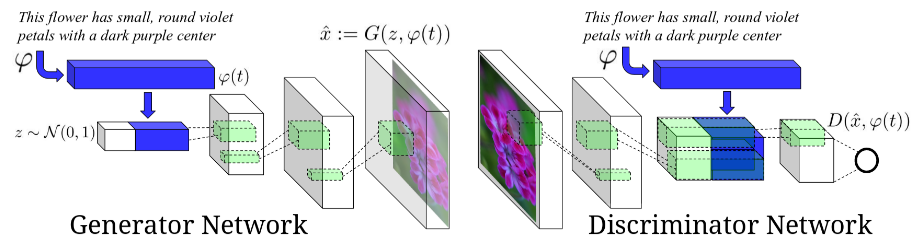

### DCGAN
- DCGAN은 GAN에 Convolutional NN Layer를 적용하여 training을 안정화했고, GAN의 Generator와 Discriminator의 내부 네트워크를 이해할 수 있게 했다.
- Convolutional RNN으로 encoding한 text features와 DCGAN을 활용해서 이미지를 합성한다.

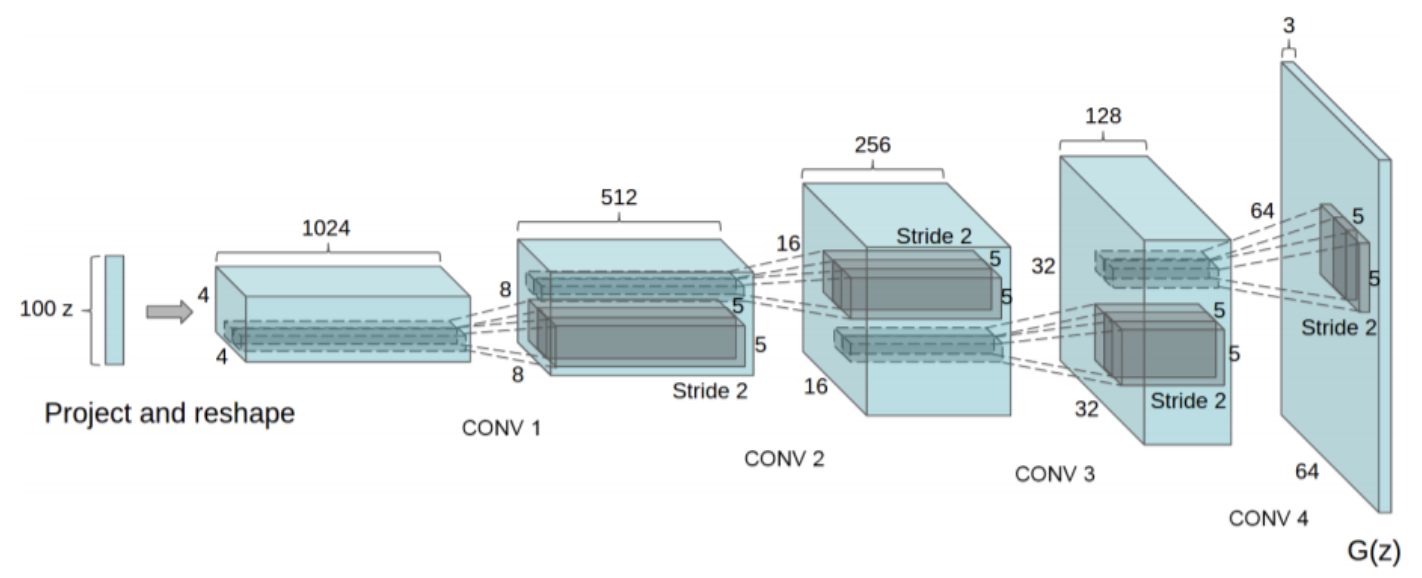

### Generator
1. `text encoder φ`를 사용해서 `text query t`를 encoding 한다.
2. encoding의 결과값`(φ(t))`을 FC layer에 넣어 compress한 후 Leaky-ReLU를 사용해서 128-dim의 작은 차원으로 compression한다.
3. 이 값을 `noise vector z`와 concate한후 deconvolutional network를 통해 generate image를 얻는다.

### Discriminator
1. stride-2 convolution layer와 BN기법, leaky ReLU function을 이용해서 학습을 한다.
2. 1번의 과정을 4x4 conv layer가 될때까지 반복한다. (여러개의 layer를 쌓음)
3. 4x4 conv layer가 되면 compressiong된 `embedding vector φ`를 여러개 복사해서 conv layer 뒤에 이어붙인다.(depth concatenation)
4. 1x1 conv layer가 되도록 연산을 한 후 final score를 얻는다.
5. 이때 모든 conv layer에 대해서 BN을 해준다.

## Matching-aware discriminator (GAN-CLS)
- conditional GAN은 discriminator가 (text, images) pair가 진짜인지 가짜인지 판단하도록 학습한다. 이때 문제점은 discriminator는 real training image가 어떤 text embedding context와 match되는지 모른다는 점이다.
- 즉, real image가 자기를 설명하지 않은 text와 match될 수도 있다.(mismatch)
- 따라서 (real image, mismatched text term)을 추가하도록 GAN training algorithm을 수정하여 discriminator가 fake에 대해서도 학습을 할 수 있게 한다.

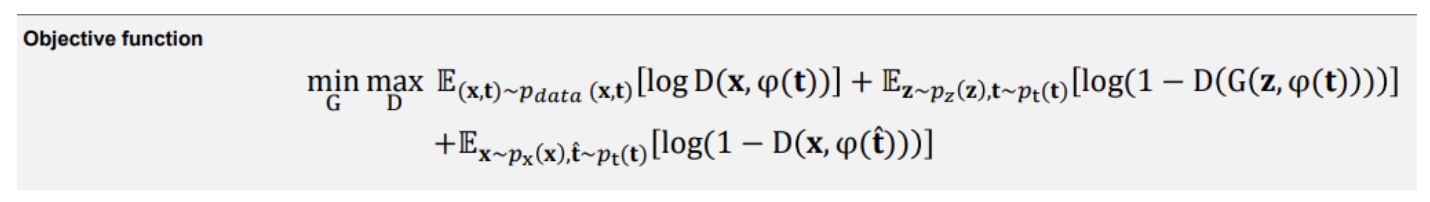

## Learning with manifold interpolation (GAN-INT)
- 우리가 네트워크를 학습시킬 때에는 주어진 text만을 가지고 image를 만들지만, 실제로 이를 사용할 때에는 training dataset에 없는 text를 줘도 image를 생성할 수 있어야한다.
- 즉, training dataset에 있는 text와 비슷한 text를 입력했을 때에도 image를 생성해야하기 때문에 interpolation의 방식을 사용하면 조금 더 효과적으로 학습을 할 수 있게 된다.

## Inverting the generator for style transferPermalink
- `text encoding φ(t)`는 image content(ex. flower shape, colors)를 찾아내는 역할을 한다. (text에서 이미지로 표현할 만한 feature들을 추출) 이미지를 생성하려면 사물의 특징들을 잘 추출하여 생성하는 것도 중요하지만, 그 외의 정보들(ex.배경이나 자세)들을 생성하는 것도 중요하다.

## Qualitative Results

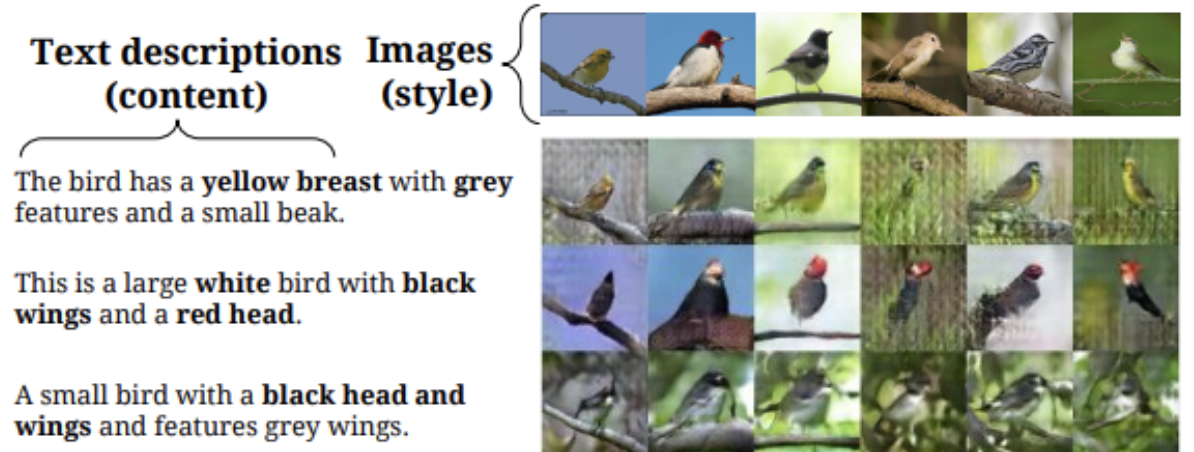

# [Download Dataset](https://www.kaggle.com/datasets/kmahesh541/flowershd5dataset/data)

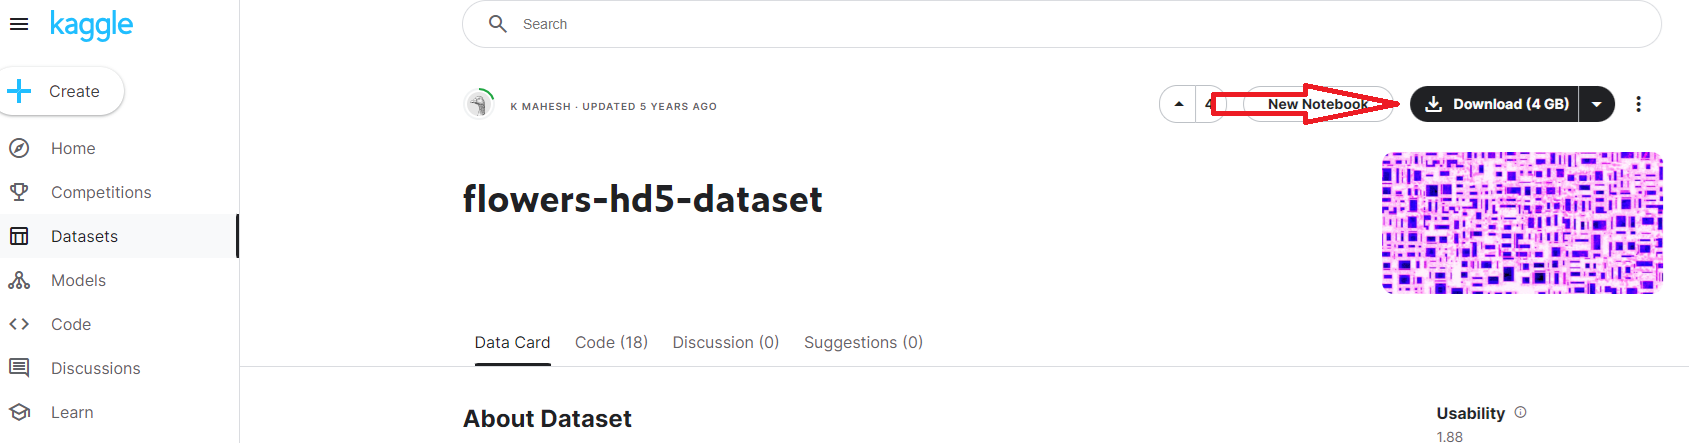

In [1]:
# 구글 드라이브 연결(데이터 로드를 위해서)
try:
    from google.colab import drive

    drive.mount('/content/data')
    dataset_root = "/content/data/MyDrive/google_lecture1/06. deep learning/4. Vision-NLP Pytorch/data/flowers hd5"
except:
    dataset_root = "./data/flowers hd5"

Mounted at /content/data


# [DCGAN - 예제](https://github.com/yashashwita20/text-to-image-using-GAN/blob/main/DCGAN_Text2Image.ipynb)

## Setup

In [2]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import os
import io
import time
import imageio
import numpy as np
from datetime import datetime

from PIL import Image
import matplotlib.pyplot as plt

import h5py

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)

Using Device cuda


In [4]:
# saving current date and time
date = datetime.now().strftime('%Y%m%d')
start_time = time.time()

In [5]:
# directory to store output images
output_save_path = './generated_images/'
os.makedirs(output_save_path, exist_ok=True)

In [6]:
# directory to store trained models
model_save_path = './saved_models/'
os.makedirs(model_save_path, exist_ok=True)

In [7]:
# setting up parameters
noise_dim = 100
embed_dim = 1024
embed_out_dim = 128
batch_size = 256 #128
real_label = 1.
fake_label = 0.
learning_rate = 0.0002
l1_coef = 50
l2_coef = 100

num_epochs = 100 #250
log_interval = 50 #43

## Dataset

In [8]:
class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        # pdb.set_trace()

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:

            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)

In [9]:
# loading dataset
train_dataset = Text2ImageDataset(dataset_root+"/flowers.hdf5",split=0) # split { 0: train, 1: validation, 2: test }
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=8)
print("Number of batches: ",len(train_loader))

Number of batches:  115


In [11]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

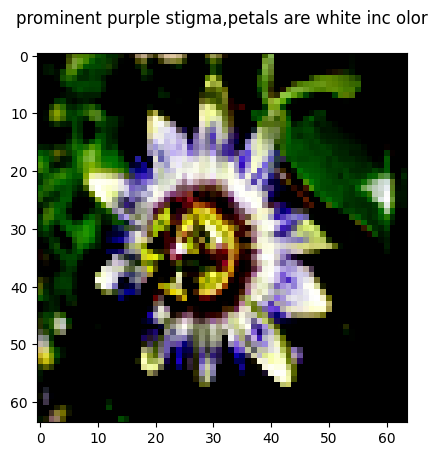

In [12]:
show_image(train_dataset[0]['right_images'], train_dataset[0]['txt'])

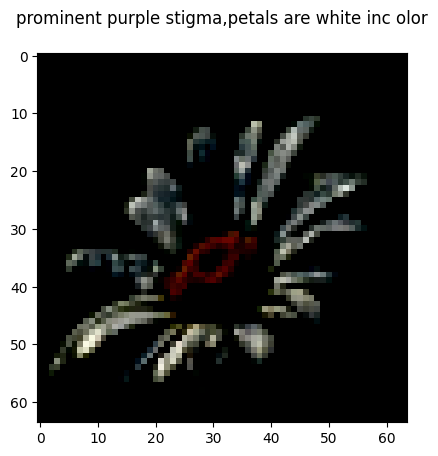

In [16]:
show_image(train_dataset[0]['wrong_images'], train_dataset[0]['txt'])

## Loss function

In [15]:
# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

## Model

In [17]:
# The Generator model
class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Text embedding layers
        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Generator architecture
        model = []
        model += self._create_layer(self.noise_dim + self.embed_out_dim, 512, 4, stride=1, padding=0)
        model += self._create_layer(512, 256, 4, stride=2, padding=1)
        model += self._create_layer(256, 128, 4, stride=2, padding=1)
        model += self._create_layer(128, 64, 4, stride=2, padding=1)
        model += self._create_layer(64, self.channels, 4, stride=2, padding=1, output=True)

        self.model = nn.Sequential(*model)

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, output=False):
        layers = [nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, bias=False)]
        if output:
            layers.append(nn.Tanh())  # Tanh activation for the output layer
        else:
            layers += [nn.BatchNorm2d(size_out), nn.ReLU(True)]  # Batch normalization and ReLU for other layers
        return layers

    def forward(self, noise, text):
        # Apply text embedding to the input text
        text = self.text_embedding(text)
        text = text.view(text.shape[0], text.shape[1], 1, 1)  # Reshape to match the generator input size
        z = torch.cat([text, noise], 1)  # Concatenate text embedding with noise
        return self.model(z)

In [ ]:
# The Embedding model
class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)  # Resize to match the discriminator input size
        out = torch.cat([x, embed_out_resize], 1)  # Concatenate text embedding with the input feature map
        return out

In [ ]:
# The Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Discriminator architecture
        self.model = nn.Sequential(
            *self._create_layer(self.channels, 64, 4, 2, 1, normalize=False),
            *self._create_layer(64, 128, 4, 2, 1),
            *self._create_layer(128, 256, 4, 2, 1),
            *self._create_layer(256, 512, 4, 2, 1)
        )
        self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)  # Text embedding module
        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, normalize=True):
        layers = [nn.Conv2d(size_in, size_out, kernel_size=kernel_size, stride=stride, padding=padding)]
        if normalize:
            layers.append(nn.BatchNorm2d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, x, text):
        x_out = self.model(x)  # Extract features from the input using the discriminator architecture
        out = self.text_embedding(x_out, text)  # Apply text embedding and concatenate with the input features
        out = self.output(out)  # Final discriminator output
        return out.squeeze(), x_out

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
def process_caption(caption, max_caption_length=200, alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "):
    """
    Converts a caption string to a tensor of one-hot encoded vectors based on the given alphabet.

    Args:
        caption (str): The input caption to be converted to one-hot encoded vectors.
        max_caption_length (int): The maximum length of the output label sequence. If the caption is longer, it will be truncated.
        alphabet (str, optional): The alphabet used to map characters to numeric labels and define the length of the one-hot vectors. Default is a combination of lowercase letters, numbers, and common punctuation marks.

    Returns:
        torch.Tensor: A tensor containing the one-hot encoded vectors for the caption.
    """
    # Convert the caption to lowercase for case-insensitivity
    caption = caption.lower()

    # Create a mapping from characters in the alphabet to numeric labels
    alpha_to_num = {k: v + 1 for k, v in zip(alphabet, range(len(alphabet)))}

    # Initialize the output tensor with zeros and set the data type to long
    labels = torch.zeros(max_caption_length).long()

    # Determine the maximum number of characters to process from the caption
    max_i = min(max_caption_length, len(caption))

    # Convert each character in the caption to its corresponding numeric label
    for i in range(max_i):
        # If the character is not in the alphabet, use the numeric label for space (' ')
        labels[i] = alpha_to_num.get(caption[i], alpha_to_num[' '])

    labels = labels.unsqueeze(1)

    # Convert the numeric labels to one-hot encoded vectors
    # Initialize a tensor of zeros with the shape (sequence length, alphabet length + 1) and scatter ones based on the labels
    one_hot = torch.zeros(labels.size(0), len(alphabet) + 1).scatter_(1, labels, 1.)

    # Remove the column corresponding to the numeric label 0 (used for padding)
    one_hot = one_hot[:, 1:]

    # Permute the tensor to have the sequence length as the first dimension
    one_hot = one_hot.permute(1, 0)

    return one_hot

## Training

In [ ]:
# lists to store losses
D_losses = []
G_losses = []

In [ ]:
# initializing generator
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [ ]:
# initializing discriminator
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, mo

In [ ]:
# setting up Adam optimizer for Generator and Discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
from tqdm.notebook import tqdm
# training loop

# iterating over number of epochs
for epoch in tqdm(range(num_epochs)):

    batch_time = time.time()

    #iterating over each batch
    for batch_idx,batch in enumerate(train_loader):

        # reading the data into variables and moving them to device
        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embeddings = batch['right_embed'].to(device)
        batch_size = images.size(0)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Clear gradients for the discriminator
        optimizer_D.zero_grad()

        # Generate random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate fake image batch with the generator
        fake_images = generator(noise, embeddings)

        # Forward pass real batch and calculate loss
        real_out, real_act = discriminator(images, embeddings)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))

        # Forward pass wrong batch and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embeddings)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))

        # Forward pass fake batch and calculate loss
        fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
        d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))

        # Compute total discriminator loss
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake

        # Backpropagate the gradients
        d_loss.backward()

        # Update the discriminator
        optimizer_D.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Clear gradients for the generator
        optimizer_G.zero_grad()

        # Generate new random noise
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)

        # Generate new fake images using Generator
        fake_images = generator(noise, embeddings)

        # Get discriminator output for the new fake images
        out_fake, act_fake = discriminator(fake_images, embeddings)

        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embeddings)

        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device))
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())

        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2

        # Backpropagate the gradients
        g_loss.backward()

        # Update the generator
        optimizer_G.step()

        # adding loss to the list
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())

        # progress based on log_interval
        if epoch % 10 == 0 and (batch_idx+1) % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
                          epoch+1, batch_idx+1, len(train_loader),
                          d_loss.mean().item(),
                          g_loss.mean().item(),
                          time.time() - batch_time))

        # storing generator output after every 10 epochs
        if batch_idx == len(train_loader)-1 and ((epoch+1)%10==0 or epoch==0):
            viz_sample = torch.cat((images[:32], fake_images[:32]), 0)
            vutils.save_image(viz_sample,
            os.path.join(output_save_path, 'output_{}_epoch_{}.png'.format(date,epoch+1)),
                              nrow=8,normalize=True)

# saving the trained models
torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_{}.pth'.format(date)))
torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator_{}.pth'.format(date)))

print('Total train time: {:.2f}'.format(time.time() - start_time))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1 [50/115] loss_D: 1.7961 loss_G: 24.5808 time: 27.94
Epoch 1 [100/115] loss_D: 1.6496 loss_G: 25.9792 time: 51.79
Epoch 11 [50/115] loss_D: 1.7040 loss_G: 24.8135 time: 27.49
Epoch 11 [100/115] loss_D: 1.8569 loss_G: 23.9638 time: 50.70
Epoch 21 [50/115] loss_D: 1.8710 loss_G: 24.2872 time: 28.05
Epoch 21 [100/115] loss_D: 1.8979 loss_G: 23.6198 time: 51.38
Epoch 31 [50/115] loss_D: 1.9481 loss_G: 23.8552 time: 26.77
Epoch 31 [100/115] loss_D: 1.8008 loss_G: 23.3928 time: 49.98
Epoch 41 [50/115] loss_D: 1.8611 loss_G: 24.1864 time: 27.39
Epoch 41 [100/115] loss_D: 1.7801 loss_G: 23.6432 time: 50.40
Epoch 51 [50/115] loss_D: 1.5964 loss_G: 22.2565 time: 27.60
Epoch 51 [100/115] loss_D: 1.6604 loss_G: 21.8972 time: 50.97
Epoch 61 [50/115] loss_D: 1.5751 loss_G: 21.0091 time: 26.88
Epoch 61 [100/115] loss_D: 1.6382 loss_G: 21.9568 time: 49.86
Epoch 71 [50/115] loss_D: 1.8421 loss_G: 19.7969 time: 27.28
Epoch 71 [100/115] loss_D: 1.7001 loss_G: 20.5908 time: 50.57
Epoch 81 [50/115] 

## loss plot

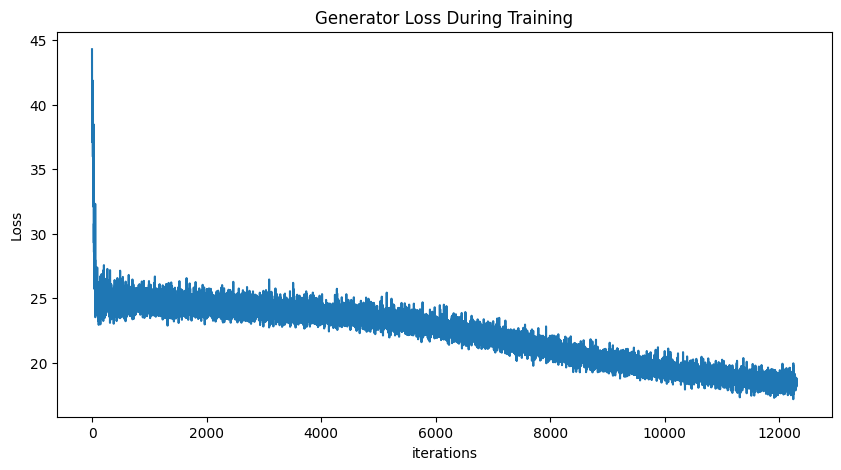

<Figure size 640x480 with 0 Axes>

In [ ]:
# generator loss plot
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_generatorLoss_{}.png'.format(date)))

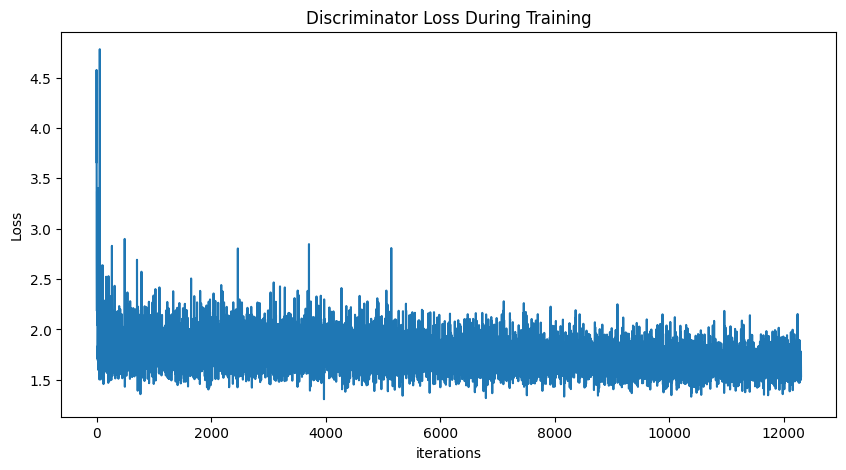

<Figure size 640x480 with 0 Axes>

In [ ]:
# discriminator loss plot
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_discriminatorLoss_{}.png'.format(date)))

## Visualize output

In [ ]:
# Get all file names from the "generated_images" directory
file_names = os.listdir(output_save_path)
file_names = [name for name in file_names if name.startswith('output_{}_'.format(date))]

# Sort the file names numerically
file_names = sorted(file_names, key=lambda name: int(name.split('_')[3].split('.')[0]))

# Create a list to store the read images
images = []

for file_name in file_names:
    images.append(imageio.imread(os.path.join(output_save_path,file_name)))

imageio.mimsave(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)), images, fps=1)

In [ ]:
from IPython.display import Image

# Load the GIF
with open(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)),'rb') as file:
    display(Image(file.read()))

Output hidden; open in https://colab.research.google.com to view.

# [XLNet - 예제](https://www.kaggle.com/code/avikbanik/text-to-image-xlnet-pytorch/notebook)
- XLNet은 당시 대부분의 NLP 테스크들에서 state-of-the-art 성능을 달성하고 있던 BERT를 큰 차이로 outperform 하면서 파장을 일으켰습니다.
- XLNet은 GPT로 대표되는 auto-regressive(AR) 모델과 BERT로 대표되는 auto-encoder(AE) 모델의 장점만을 합한 generalized AR pretraining model입니다.


In [ ]:
import os
import io
import h5py
import torch
import ipywidgets
import numpy as np
from torch import nn
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import XLNetTokenizer, XLNetModel
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit

## Dataset

In [ ]:
training = 1
num_epoch = 20 #25
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
kernel_root = ""

In [ ]:
class TrainDataset:
    def __init__(self, dataset_root, kernel_root):
        self.tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

        if os.path.exists(os.path.join(kernel_root, "data.npy")):
            self.data = np.load(os.path.join(kernel_root, "data.npy"), allow_pickle=True)
        else:
            f = h5py.File(os.path.join(dataset_root, "flowers.hdf5"), mode="r")
            self.data = self.prepareData(f['train'])
        np.save('data.npy', self.data)
        self.max_seq_len = max(map(lambda x: len(x["text"]["input_ids"]), self.data))

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=(90, 90)),
            transforms.RandomRotation(degrees=(180, 180)),
            transforms.RandomRotation(degrees=(270, 270)),
            transforms.RandomVerticalFlip(p=1),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
        ])

    def prepareData(self, data):
        preparedData = []
        for idx, img_name in enumerate(tqdm(data)):
            image = np.array(Image.open(io.BytesIO(bytes(np.array(data[img_name]['img'])))).resize((256,256)))
            text = np.array(data[img_name]['txt']).item().strip().decode('utf-8')
            input_ids = self.tokenizer.encode(text)
            token_type_ids = [0] * (len(input_ids) - 1) + [1]
            attention_mask = [1] * len(token_type_ids)
            preparedData.append({
                "image": image,
                "text": {
                    "input_ids": input_ids,
                    "token_type_ids": token_type_ids,
                    "attention_mask": attention_mask
                },
            })
        return preparedData

    def padTokens(self, text_dict):
        pad_len = self.max_seq_len - sum(text_dict["attention_mask"])
        text_dict['input_ids'] =  [5] * pad_len + text_dict['input_ids'] # <pad> = 5
        text_dict['token_type_ids'] =  [2] * pad_len + text_dict['token_type_ids']
        text_dict['attention_mask'] = [0] * pad_len + text_dict['attention_mask']
        return text_dict

    @staticmethod
    def collate_fn_module(batch, idx):
        images, texts = [], {}
        for data in batch:
            images.append(data[idx][0])
            for key in data[idx][1]:
                if key not in texts:
                    texts[key] = []
                texts[key].append(data[0][1][key])

        images = torch.stack(images).to(device)
        for key in texts:
            texts[key] = torch.tensor(texts[key]).to(device)
        return images, texts

    def collate_fn(self, batch):
        right_images, right_texts = self.collate_fn_module(batch, 0)
        wrong_images, wrong_texts = self.collate_fn_module(batch, 1)
        return (right_images, right_texts), (wrong_images, wrong_texts)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, right_idx):
        right_data = self.data[right_idx].copy()
        right_image = self.transforms(Image.fromarray(right_data["image"]))
        right_text = self.padTokens(right_data["text"].copy())

        wrong_idx = np.random.choice([(i) for i in range(len(self.data)) if i != right_idx])
        wrong_data = self.data[wrong_idx].copy()
        wrong_image = self.transforms(Image.fromarray(wrong_data["image"]))
        wrong_text = self.padTokens(wrong_data["text"].copy())
        return (right_image, right_text), (wrong_image, wrong_text)

In [ ]:
%%time
train_dataset = TrainDataset(dataset_root, kernel_root)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

  0%|          | 0/29390 [00:00<?, ?it/s]

CPU times: user 3min 31s, sys: 13.1 s, total: 3min 44s
Wall time: 4min 31s


In [ ]:
def visualize(image, text, tokenizer=None, ax = None, title = None, fig = None):
    if ax is None: _, ax = plt.subplots(1, 1, figsize = (10, 10))
    if title: ax.set_title(title)
    ax.imshow(image.permute(1, 2, 0))
    if tokenizer== None:
        pass
    else:
        fig.suptitle(tokenizer.decode([t for t in text["input_ids"] if t != 5])) # figure 제목
        # ax.set_xlabel(tokenizer.decode([t for t in text["input_ids"] if t != 5]))

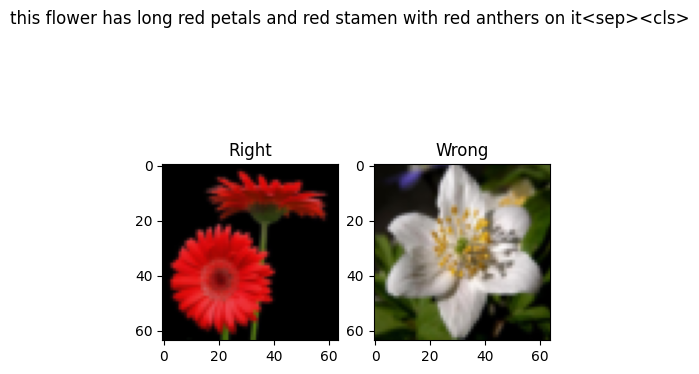

In [ ]:
idx = np.random.randint(len(train_dataset))
right, wrong = train_dataset[idx]
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
axs = axs.flatten()

visualize(*right, train_dataset.tokenizer, axs[0], "Right", fig)
visualize(*wrong, ax = axs[1], title = "Wrong")
plt.show()

## DataLoader

In [ ]:
if os.path.exists(os.path.join(kernel_root, 'checkpoint.pth')):
    checkpoint = torch.load(os.path.join(kernel_root, 'checkpoint.pth'), map_location=device)
    torch.save(checkpoint, "checkpoint.pth")
else:
    checkpoint = {}

In [ ]:
train_indices = checkpoint.get('train_indices', None)
valid_indices = checkpoint.get('valid_indices', None)
if train_indices is None or valid_indices is None:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
    splitter = sss.split(train_dataset, np.array([len(x["text"]["input_ids"])%10 for x in train_dataset.data]))
    train_indices, valid_indices = next(splitter)
# Creating PT data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler, collate_fn=train_dataset.collate_fn, drop_last=True)

## Model

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = XLNetModel.from_pretrained("xlnet-base-cased")

    def forward(self, input_ids, token_type_ids, attention_mask):
        hidden = self.transformer(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        ).last_hidden_state
        context = hidden.mean(dim=1)
        context = context.view(*context.shape, 1, 1)
        return context

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz=100, nt=768, nc=3, ngf=64):
        super().__init__()

        self.layer1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz + nt, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            # nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
        )

            # Completed - TODO: check out paper's code and add layers if required

            ##there are more conv2d layers involved here in
            # https://github.com/reedscot/icml2016/blob/master/main_cls.lua
        self.layer2 = nn.Sequential(
            nn.Conv2d(ngf*8,ngf*2,1,1),
            nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*2,3,1,1),
            nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(ngf*2,ngf*8,3,1,1),
            nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # nn.SELU(True),
        )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            # nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
        )

            # Completed - TODO: check out paper's code and add layers if required

            ##there are more conv2d layers involved here in
            # https://github.com/reedscot/icml2016/blob/master/main_cls.lua

        self.layer6 = nn.Sequential(
            nn.Conv2d(ngf*4,ngf,1,1),
            nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(ngf,ngf,3,1,1),
            nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(ngf,ngf*4,3,1,1),
            nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # nn.SELU(True),
        )
        self.layer9 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # nn.SELU(True),

            # state size. (ngf*2) x 16 x 16
        )
        self.layer10 = nn.Sequential(
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # nn.SELU(True),

            # state size. (ngf) x 32 x 32
        )
        self.layer11 = nn.Sequential(
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self,noise,encoded_text):
        x = torch.cat([noise,encoded_text],dim=1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64, nt=768):
        super().__init__()
        self.layer1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),

            nn.Conv2d(ndf*8,ndf*2,1,1),
            # nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer5 = nn.Sequential(

            nn.Conv2d(ndf*2,ndf*2,3,1,1),
            # nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.layer6 = nn.Sequential(

            nn.Conv2d(ndf*2,ndf*8,3,1,1),
            # nn.Dropout2d(inplace=True),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.concat_image_n_text = nn.Sequential(
            nn.Conv2d(ndf * 8 + nt, ndf * 8, 1, 1, 0, bias=False), ## TODO: Might want to change the kernel size and stride
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(ndf * 8, 2, 4, 1, 0, bias=False),
            nn.Flatten(start_dim=1)
        )

    def forward(self, x, encoded_text):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
#         print(x.shape)
        x = torch.cat([x, encoded_text.repeat(1, 1, 4, 4)], dim=1)
        x = self.concat_image_n_text(x)
        return x

In [ ]:
models = {
    "text_encoder": TextEncoder().to(device),
    "generator": Generator().to(device),
    "discriminator": Discriminator().to(device)
}
optimizers = {}
schedulers = {}
criterion = nn.CrossEntropyLoss()
learning_rates = {"text_encoder": 1e-4, "generator": 5e-4, "discriminator": 1e-4}
for key in models:
    if key == "text_encoder": continue
    models[key].load_state_dict(checkpoint.get("models", {}).get(key, models[key].state_dict()))
    # Prepare optimizer and schedule (linear warmup and decay)
    optimizers[key] = torch.optim.Adam(models[key].parameters(), lr=learning_rates[key], weight_decay=1e-6)
    optimizers[key].load_state_dict(checkpoint.get("optimizers", {}).get(key, optimizers[key].state_dict()))
    schedulers[key] = torch.optim.lr_scheduler.StepLR(optimizers[key], step_size=50, gamma=0.1, last_epoch=-1)
    schedulers[key].load_state_dict(checkpoint.get("schedulers", {}).get(key, schedulers[key].state_dict()))

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

## Train

In [ ]:
def valid():
    total_dis_loss, total_gen_loss = 0, 0
    total_dis_score, total_gen_score = 0, 0
    template = "Dis Loss: {:.4f}, Dis Score: {:.4f}, Gen Loss: {:.4f}, Gen Score: {:.4f}"
    for key in models:
        models[key].eval()
    loader = tqdm(valid_loader, desc = f"Validating")
    for idx, ((right_images, right_texts), (wrong_images, wrong_texts)) in enumerate(loader, start=1):
        # Execute
        with torch.no_grad():
            enc_right_texts = models["text_encoder"](**right_texts).detach()
            enc_wrong_texts = models["text_encoder"](**wrong_texts).detach()

            noise = torch.randn((len(right_images), 100, 1, 1),device = device)
            ones = torch.ones((len(right_images)), dtype=torch.long, device=device)
            zeros = torch.zeros((len(right_images)), dtype=torch.long, device=device)
            fake_images = models["generator"](noise, enc_right_texts)

            dis_right_logits = models["discriminator"](right_images, enc_right_texts)
            dis_wrong_text_logits =  models["discriminator"](right_images, enc_wrong_texts)
            dis_wrong_image_logits =  models["discriminator"](wrong_images, enc_right_texts)
            dis_fake_logits = models["discriminator"](fake_images.detach(), enc_right_texts)

            dis_real_loss = criterion(dis_right_logits, ones)
            dis_wrong_text_loss = criterion(dis_wrong_text_logits, zeros)
            dis_wrong_image_loss = criterion(dis_wrong_image_logits, zeros)
            dis_fake_loss = criterion(dis_fake_logits, zeros)
            dis_loss = dis_real_loss + 0.25*dis_wrong_text_loss + 0.25*dis_wrong_image_loss + 0.5*dis_fake_loss

            dis_fake_logits = models["discriminator"](fake_images, enc_right_texts)
            gen_loss = criterion(dis_fake_logits, ones)

        dis_score, gen_score = torch.tensor(0), torch.tensor(0)

        total_dis_loss += dis_loss.item(); total_gen_loss += gen_loss.item()
        total_dis_score += dis_score.item(); total_gen_score += gen_score.item()
        # print statistics
        loader.set_postfix_str(template.format(dis_loss, dis_score, gen_loss, gen_score))
        loader.update()
        # Clear variable
        del right_images; del right_texts; del wrong_images; del wrong_texts
        del enc_right_texts; del enc_wrong_texts; del noise; del fake_images
        del ones; del zeros; del dis_right_logits; del dis_wrong_text_logits
        del dis_wrong_image_logits; del dis_fake_logits; del dis_real_loss
        del dis_wrong_text_loss; del dis_wrong_image_loss; del dis_fake_loss
        del dis_loss; del gen_loss; del dis_score; del gen_score
        torch.cuda.empty_cache()
    template = template.format(total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx)
    loader.write(f"Validated | {template}")
    return total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx

In [ ]:
def train():
    total_dis_loss, total_gen_loss = 0, 0
    total_dis_score, total_gen_score = 0, 0
    template = "Dis Loss: {:.4f}, Dis Score: {:.4f}, Gen Loss: {:.4f}, Gen Score: {:.4f}"
    for key in models:
        models[key].train()
    loader = tqdm(train_loader, desc = f"Training")
    for idx, ((right_images, right_texts), (wrong_images, wrong_texts)) in enumerate(loader, start=1):
        # Execute
        enc_right_texts = models["text_encoder"](**right_texts).detach()
        enc_wrong_texts = models["text_encoder"](**wrong_texts).detach()

        noise = torch.randn((len(right_images), 100, 1, 1), device=device)
        ones = torch.ones((len(right_images)), dtype=torch.long, device=device)
        zeros = torch.zeros((len(right_images)), dtype=torch.long, device=device)
        fake_images = models["generator"](noise, enc_right_texts)

        dis_right_logits = models["discriminator"](right_images, enc_right_texts)
        dis_wrong_text_logits = models["discriminator"](right_images, enc_wrong_texts)
        dis_wrong_image_logits = models["discriminator"](wrong_images, enc_right_texts)
        dis_fake_logits = models["discriminator"](fake_images.detach(), enc_right_texts)

        dis_real_loss = criterion(dis_right_logits, ones)
        dis_wrong_text_loss = criterion(dis_wrong_text_logits, zeros)
        dis_wrong_image_loss = criterion(dis_wrong_image_logits, zeros)
        dis_fake_loss = criterion(dis_fake_logits, zeros)
        dis_loss = dis_real_loss + 0.25*dis_wrong_text_loss + 0.25*dis_wrong_image_loss + 0.5*dis_fake_loss

        optimizers["discriminator"].zero_grad()
        dis_loss.backward()
        optimizers["discriminator"].step()

        dis_fake_logits = models["discriminator"](fake_images, enc_right_texts)
        gen_loss = criterion(dis_fake_logits, ones)
        optimizers["generator"].zero_grad()
        gen_loss.backward()
        optimizers["generator"].step()

        dis_score, gen_score = torch.tensor(0), torch.tensor(0)

        total_dis_loss += dis_loss.item(); total_gen_loss += gen_loss.item()
        total_dis_score += dis_score.item(); total_gen_score += gen_score.item()
        # print statistics
        loader.set_postfix_str(template.format(dis_loss, dis_score, gen_loss, gen_score))
        loader.update()
        # Clear variable
        del right_images; del right_texts; del wrong_images; del wrong_texts
        del enc_right_texts; del enc_wrong_texts; del noise; del fake_images
        del ones; del zeros; del dis_right_logits; del dis_wrong_text_logits
        del dis_wrong_image_logits; del dis_fake_logits; del dis_real_loss
        del dis_wrong_text_loss; del dis_wrong_image_loss; del dis_fake_loss
        del dis_loss; del gen_loss; del dis_score; del gen_score
        torch.cuda.empty_cache()
    template = template.format(total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx)
    loader.write(f"Trained | {template}")
    for key in schedulers:
        schedulers[key].step()
    return total_dis_loss/idx, total_dis_score/idx, total_gen_loss/idx, total_gen_score/idx

In [ ]:
train_data = checkpoint.get('train_data', np.empty((0, 4)))
valid_data = checkpoint.get('valid_data', np.empty((0, 4)))
epoch_data = checkpoint.get('epoch_data', [])
# del checkpoint
def plot_training_data(ax, epoch_data, train_data, valid_data):
    ax[0].clear(); ax[1].clear(); ax[2].clear(); ax[3].clear()
    ax[0].plot(epoch_data, train_data[:, 0], label = f"Train dis loss {train_data[-1, 0]:.4f}")
    ax[0].plot(epoch_data, valid_data[:, 0], label = f"Valid dis loss {valid_data[-1, 0]:.4f}")
    ax[1].plot(epoch_data, train_data[:, 1], label = f"Train dis score {train_data[-1, 1]:.4f}")
    ax[1].plot(epoch_data, valid_data[:, 1], label = f"Valid dis score {valid_data[-1, 1]:.4f}")
    ax[2].plot(epoch_data, train_data[:, 2], label = f"Train gen loss {train_data[-1, 2]:.4f}")
    ax[2].plot(epoch_data, valid_data[:, 2], label = f"Valid gen loss {valid_data[-1, 2]:.4f}")
    ax[3].plot(epoch_data, train_data[:, 3], label = f"Train gen score {train_data[-1, 3]:.4f}")
    ax[3].plot(epoch_data, valid_data[:, 3], label = f"Valid gen score {valid_data[-1, 3]:.4f}")
    ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend()
if epoch_data:
    fig, ax = plt.subplots(1, 4, figsize=(10*4, 5))
    plot_training_data(ax, epoch_data, train_data, valid_data)
    plt.show()

In [ ]:
loader = tqdm(range(len(epoch_data), len(epoch_data) + num_epoch * training), desc = "Epoch")
board = ipywidgets.Output()
if training: display.display(board)
graph = display.display(ipywidgets.widgets.HTML(f"<b>Training statred: {bool(training)}</b>"), display_id = True)
for i in loader:
    with board:
        epoch_data.append(i+1)
        # Make grid
        fig, ax = plt.subplots(1, 4, figsize=(10*4, 5))
        # Close figure
        plt.close(fig)
        train_data = np.append(train_data, [train()], axis = 0)
        valid_data = np.append(valid_data, [valid()], axis = 0)
        # Visualize
        plot_training_data(ax, epoch_data, train_data, valid_data)
        graph.update(fig)
        # Clear all progress bar with in board widget
        display.clear_output()
        graph = display.display(fig, display_id = True)
    # Save model
    params = {
        'models': dict([(key, models[key].state_dict()) for key in models]),
        'optimizers': dict([(key, optimizers[key].state_dict()) for key in optimizers]),
        'schedulers': dict([(key, schedulers[key].state_dict()) for key in schedulers]),
        'train_indices': train_indices,
        'valid_indices': valid_indices,
        'train_data': train_data,
        'valid_data': valid_data,
        'epoch_data': epoch_data
    }
    torch.save(params, "checkpoint.pth")
loader.write("Done!")

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Output()

HTML(value='<b>Training statred: True</b>')

Done!


## Predict

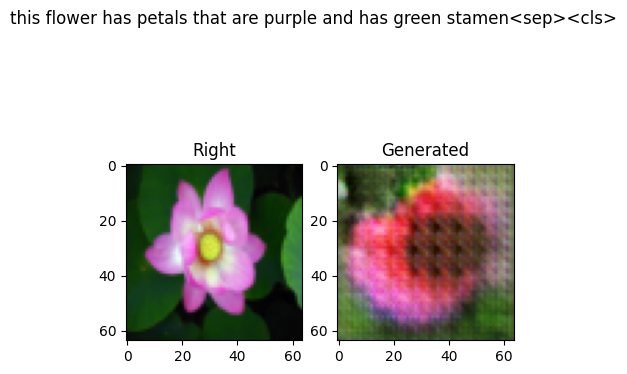

In [ ]:
idx = np.random.randint(len(train_dataset))
(image, text), _ = train_dataset[idx]
params = {}
for key in text:
    params[key] = torch.tensor(text[key], device=device)[None]
for key in models:
    models[key].eval()
enc_text = models["text_encoder"](**params)
noise = torch.randn((1, 100, 1, 1), device=device)
gen_image = models["generator"](noise, enc_text).detach().squeeze().cpu()

fig, axs = plt.subplots(1, 2, figsize=(5, 5))
visualize(image, text, train_dataset.tokenizer, axs[0], "Right", fig)
visualize(gen_image, text, None, axs[1], "Generated")
plt.show()